<a href="https://colab.research.google.com/github/LCaravaggio/AnalisisPredictivo/blob/master/Ejercicio_Sencillo_Alphacast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



Ejercicio sencillo con Alphacast
Original: https://t.co/8sDEm7wbbh



In [1]:
# Impotar librerías

import pandas as pd
import requests
from requests.auth import HTTPBasicAuth
import csv
import datetime
from datetime import datetime as dt
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas_profiling as ppf
from dateutil.relativedelta import relativedelta

import json
from google.colab import drive

In [2]:
drive.mount('/content/drive', force_remount=True)
with open("/content/drive/My Drive/alphacast.json", 'r') as f:
    api_token= json.load(f)

Mounted at /content/drive


In [3]:
# Definir user key para la API
user_key = api_token["key"]

In [4]:
# Función para obtener el primer día del mes solicitado
def changeday(date):
    year = date.year
    month = date.month
    return dt(year,month,1)

In [5]:
# DESCARGA DE DATOS Y ARMADO DE BASE

# Adefa
adefa = requests.get('https://charts.alphacast.io/api/datasets/5600.csv', auth=HTTPBasicAuth(user_key, ''))
open('adefa.csv', 'wb').write(adefa.content)
adefa1 = pd.read_csv('adefa.csv', delimiter = ',')
adefa1['Year'] = pd.to_datetime(adefa1['Year'])
adefa1.set_index('Year', inplace = True)
adefa1 = adefa1[['Production - Cars - sa', 'Exports - Cars - sa', 'Sales to domestic market - Total', 'Sales to domestic market - National vehicles']]
adefa1.columns = ['Produccion Automoviles Total (sa)', 'Exportacion Automoviles (sa)','Ventas Totales Mdo Domestico (sa)','Ventas de Vehiculos Nacionales Mdo Domestico']

# Portland
portland = requests.get('https://charts.alphacast.io/api/datasets/5537.csv', auth=HTTPBasicAuth(user_key, ''))
open('portland.csv','wb').write(portland.content)
portland1 = pd.read_csv('portland.csv', delimiter = ',')
portland1['Year'] = pd.to_datetime(portland1['Year'])
portland1.set_index('Year', inplace = True)
portland1 = portland1[['Cement Dispatches - Total']]
portland1.columns = ['Despachos de Cemento']

# MECON
mecon = requests.get('https://charts.alphacast.io/api/datasets/5632.csv', auth=HTTPBasicAuth(user_key, ''))
open('mecon.csv', 'wb').write(mecon.content)
mecon1 = pd.read_csv('mecon.csv', delimiter = ',')
mecon1['Year'] = pd.to_datetime(mecon1['Year'])
mecon1.set_index('Year', inplace = True)
mecon1 = mecon1[['GANANCIAS - sa', 'GANANCIAS DGI - sa', 'GANANCIAS DGA - sa', 'IVA - sa', 'IVA DGI - sa' ]]
mecon1.columns = ['Ganancias (sa)','Ganancias DGI (sa)','Ganancias DGA (sa)','IVA (sa)','IVA DGI (sa)' ]
mecon1 = mecon1.loc['2004-01-01':]

# Merval
merval = requests.get('https://charts.alphacast.io/api/datasets/5816.csv', auth=HTTPBasicAuth(user_key, ''))
open('merval.csv', 'wb').write(merval.content)
merval1 = pd.read_csv('merval.csv', delimiter = ',')
merval1['Year'] = pd.to_datetime(merval1['Year'])
merval1.set_index('Year', inplace = True)
merval1 = merval1[['MERVAL']]
merval1 = merval1.loc['2004-01-01':]
merval1.columns = ['Merval']
merval1 = merval1.resample('MS').mean()

# BCRA
bcra = requests.get('https://charts.alphacast.io/api/datasets/6054.csv', auth=HTTPBasicAuth(user_key, ''))
open('bcra.csv', 'wb').write(bcra.content)
bcra1 = pd.read_csv('bcra.csv', delimiter = ',')
bcra1['Year'] = pd.to_datetime(bcra1['Year'])
bcra1 = bcra1[['Year','Tasas de interés, promedio mensual en porcentaje nominal anual - Por depósitosa plazo fijo de 30 a 59 días de plazo - De moneda nacional']]
bcra1.columns = ['Year','Tasa de Interes']
bcra1['Year'] = bcra1['Year'].apply(lambda x: changeday(x))
bcra1.set_index('Year', inplace = True)
bcra1 = bcra1.loc["2004-01-01":]

bcra_arg = requests.get('https://charts.alphacast.io/api/datasets/5277.csv', auth=HTTPBasicAuth(user_key, ''))
open('bcra_arg.csv', 'wb').write(bcra_arg.content)
bcra_arg1 = pd.read_csv('bcra_arg.csv', delimiter = ',')
bcra_arg1['Year'] = pd.to_datetime(bcra_arg1['Year'])
bcra_arg1.set_index('Year', inplace = True)
bcra_arg1 = bcra_arg1[['Private M2 - sa']]
bcra_arg1.columns = ['Private M2 (sa)']
bcra_arg1 = bcra_arg1.loc['2004-01-01':]

# UTDT
utdt = requests.get('https://charts.alphacast.io/api/datasets/5596.csv', auth=HTTPBasicAuth(user_key, ''))
open('utdt.csv','wb').write(utdt.content)
utdt1 = pd.read_csv('utdt.csv', delimiter = ',')
utdt1['Year'] = pd.to_datetime(utdt1['Year'])
utdt1.set_index('Year', inplace = True)
utdt1 = utdt1[['Indice de Confianza del Consumidor (ICC) - Nacional']]
utdt1.columns = ['Indice de Confianza del Consumidor']
utdt1 = utdt1.loc['2004-01-01':]

# EMAE
emae = requests.get('https://charts.alphacast.io/api/datasets/5331.csv', auth=HTTPBasicAuth(user_key, ''))
open('emae.csv','wb').write(emae.content)
emae1 = pd.read_csv('emae.csv',delimiter = ',')
emae1['Year'] = pd.to_datetime(emae1['Year'])
emae1.set_index('Year', inplace = True)
emae1 = emae1[['Emae','Emae - current_prices_mom','Emae - current_prices_yoy','Emae - sa_orig','Emae - sa_orig - current_prices_mom','Emae - sa_orig - current_prices_yoy']]
emae1.columns = ['EMAE', 'EMAE MoM','EMAE YoY','EMAE (sa)','EMAE (sa) MoM','EMAE (sa) YoY']
emae1 = emae1.loc['2004-01-01':]

In [6]:
# Armado de tabla final
tabla_final = pd.concat([emae1[['EMAE (sa)']], adefa1,portland1,mecon1,bcra_arg1,utdt1,merval1,bcra1], axis = 1)

In [7]:
# Función para graficar emae vs. variable solicitada

sns.set_theme(style='darkgrid')
def graficar_corr(variable):
    fig = sns.scatterplot(x=tabla_final.transpose().loc[variable,:],y=tabla_final.transpose().loc['EMAE (sa)'])
    plt.title('EMAE (sa) vs %s'%variable)
    plt.xlabel(variable)
    plt.ylabel('EMAE (sa)')
    plt.savefig('%s.png'%variable)
    return fig

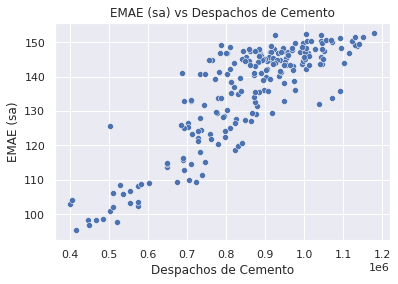

In [8]:
# Aplicación de esa función para diferentes variables
graficar_corr('Despachos de Cemento')

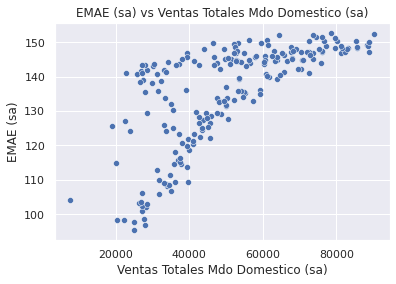

In [9]:
graficar_corr('Ventas Totales Mdo Domestico (sa)')

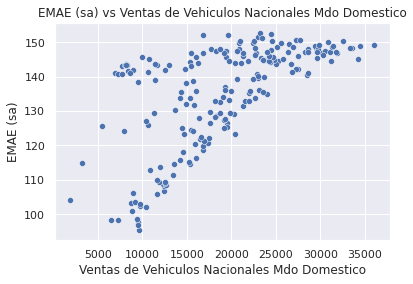

In [10]:
graficar_corr('Ventas de Vehiculos Nacionales Mdo Domestico')

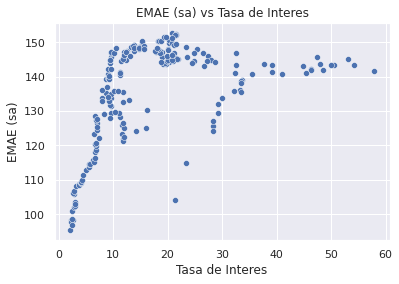

In [11]:
graficar_corr('Tasa de Interes')

In [17]:
# Función que separa la base en train set y test set, ejecuta el modelo, y aplica sobre el test set
def modelo_prueba(corte):
    scaler = StandardScaler()
    tabla_final_1 = tabla_final.copy(deep=True)
    tabla_final_1['Missing'] = tabla_final_1.isnull().sum(axis=1)
    tabla_final_1 = tabla_final_1[tabla_final_1.Missing == 0]
    tabla_final_1.drop(['Missing'], axis=1,inplace=True)
    scaler = StandardScaler()
    X = tabla_final_1.loc[:, tabla_final_1.columns != 'EMAE (sa)']
    X = scaler.fit_transform(X)
    
    # CUIDADO: En el original la estimación se hace sobre la serie desestacionalizada... esto no es del todo correcto
    y = tabla_final_1[['EMAE (sa)']].values.ravel()
    
    # CUIDADO: En el original esta partición se hace random, pero al ser series de tiempo la partición corresponde así:
    X_train, X_test = X[:corte] , X[corte:]
    y_train, y_test = y[:corte] , y[corte:]

    regr_1 = MLPRegressor(random_state=1, activation='tanh', max_iter=5000, learning_rate='adaptive', solver='sgd', momentum=0.01).fit(X_train, y_train)
    y_pred = regr_1.predict(X_test)
    model_df = pd.DataFrame({'Actual':y_test,'Pred':y_pred})
    model_df['Dif']=abs((model_df['Pred']/model_df['Actual']-1)*100)
    score = model_df['Dif'].median()
    return model_df, score, regr_1


In [18]:
# Ejecución del modelo
model_df, score, regr_prueba = modelo_prueba(30)
print('Desviación promedio: ',round(score,2),'%')

Desviación promedio:  94.96 %


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


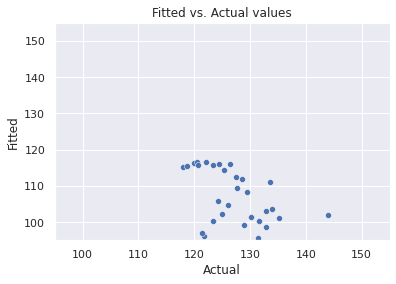

In [19]:
# Gráfico de fitted vs actual
sns.set_theme(style='darkgrid')
sns.scatterplot(x=model_df['Actual'],y=model_df['Pred'])
ax = plt.gca()
plt.title('Fitted vs. Actual values')
plt.xlabel('Actual')
plt.ylabel('Fitted')
ax.set_ylim(95,155)
ax.set_xlim(95,155)
plt.savefig('Scatter.png')

In [20]:
# Función que ejecuta el modelo para un mes determinado, utilizando solo la información que estaba disponible hasta ese momento
def estimar(fecha,tabla_final=tabla_final):
    scaler = StandardScaler()
    X = tabla_final.loc[:, tabla_final.columns != 'EMAE (sa)'].loc[:fecha]
    X = scaler.fit_transform(X)
    y = tabla_final[['EMAE (sa)']].loc[:fecha].values.ravel()
    X_train_posta = X[0:len(X)-1]
    X_target = X[len(X)-1]
    y_train_posta = y[0:len(X)-1]
    y_target = y[len(X)-1]
    regr_posta = MLPRegressor(random_state=1, activation='tanh', max_iter=5000, learning_rate='adaptive', solver='sgd', momentum=0.01).fit(X_train_posta, y_train_posta)
    y_pred_posta = regr_posta.predict(X_target.reshape(1,-1))
    dif = ((y_pred_posta/y_target)-1)*100
    return y_pred_posta, y_target, dif

In [21]:
# Ejecución del modelo para ver mayo 2021
estimar(fecha='2021-05-01')

(array([134.97702085]), 135.3784, array([-0.29648685]))

,Actual,Pred,Diff (%)
2020-07-01,126.9708,124.178688,-2.199019
2020-08-01,129.4418,129.780426,0.261605
2020-09-01,132.0110,131.109082,-0.683214
2020-10-01,133.7790,137.620356,2.871419
2020-11-01,135.6742,136.399260,0.534412
2020-12-01,136.1671,135.464790,-0.515771
2021-01-01,139.1411,130.951693,-5.885685
2021-02-01,138.5613,130.686200,-5.683477
2021-03-01,138.6433,136.209975,-1.755097
2021-04-01,138.2093,137.735160,-0.343059


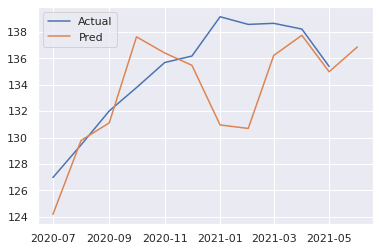

In [22]:
# Ejecución de la función anterior para los últimos 12 meses, y visualización de los resultados

m = 7 ## lo seteo en julio
meses=[]
for i in range(1,13):
    meses.append(dt(2021,m,1)+relativedelta(months=-i))
meses.sort()

posta_l=[]
pred_l=[]
dif_l=[]
for mes in meses:
    pred,posta,dif = estimar(mes)
    posta_l.append(posta)
    pred_l.append(pred[0])
    dif_l.append(dif[0])

estimar_df = pd.DataFrame(list(zip(posta_l,pred_l,dif_l)),index=meses,columns=['Actual','Pred','Diff (%)'])
plt.plot(estimar_df[['Actual']],label='Actual')
plt.plot(estimar_df[['Pred']],label='Pred')
plt.legend(loc="upper left")
plt.savefig('12 meses.png')
estimar_df